In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive/MyDrive/687-proj

/content/drive/MyDrive/687-proj


In [3]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 13.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=488aaafaeccd58059adc3354028539a3adc5d6695575c82194afc2c86868ca40
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [4]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

### Data Preprocess

In [5]:
def get_selected_genes(file_path):
  adata = sc.read_h5ad(file_path)
  df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
  var = adata.var
  selected_genes = var[var['highly_variable'] == True]
  selected_genes = list(selected_genes.index)

  return selected_genes

In [6]:
def preprocess(file_path, h5 = True):
  """
  Returns
  1. a dataframe with original label, encoded label and gene expressions
  2. label encoder mapping
  """
  global selected_genes

  if h5:
    adata = sc.read_h5ad(file_path)
    df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    var = adata.var
    selected_genes = var[var['highly_variable'] == True]
    selected_genes = list(selected_genes.index)
    df = df[selected_genes]
    df['label'] = df.index.to_series().apply(lambda x: x.split('_')[0])
    label_encoder = LabelEncoder()
    df['enc_label'] = label_encoder.fit_transform(df['label'])
    mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))) #label_to_integer_mapping
  else:
    if 'tsv' in file_path:
      df = pd.read_csv(file_path, sep = '\t')
    else:
      df = pd.read_csv(file_path)# 'data/endoderm/endoderm.csv'
    df = df.T
    df.columns = df.iloc[0]

    # Drop the first row from the DataFrame
    df = df.drop(df.index[0])
    df = df[selected_genes]
    label_encoder = LabelEncoder()
    df['label'] = df.index.to_series().apply(lambda x: x.split('_')[0])
    df['enc_label'] = label_encoder.fit_transform(df['label'])
    mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))) #label_to_integer_mapping


  return df, mapping

### Feature Selection

In [7]:
def get_feature_importance(df, filename):
  """
  Returns a dataframe with features and its corresponding importance
  Saves feature importance figure
  Saves feature importance dataframe
  """
  # Assign X and y
  X = df.drop(['enc_label','label'], axis=1)
  y = df['enc_label']

  # Fit RandomForest model and obtain feature importance
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and fit the Random Forest model
  model = RandomForestClassifier(random_state=42)  # Use RandomForestRegressor for a regression problem
  model.fit(X_train, y_train)

  feature_importances = model.feature_importances_

  # Create a DataFrame for feature importances
  features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
  features_df = features_df.sort_values(by='Importance', ascending=False)
  features_df_top = features_df.head(50) # get top 50 features

  # Visualize feature importance distribution of top features
  rainbow_palette = sns.color_palette("husl", len(features_df_top))

  plt.figure(figsize=(10, 8))
  sns.barplot(x='Importance', y='Feature', data=features_df_top, palette=rainbow_palette)
  plt.title(f'Feature Importance_{filename}')
  plt.savefig(f'feature_importance/feature_importance_{filename}.png')  # Saves the plot as a PNG file
  features_df.to_csv(f'feature_importance/feature_importance_{filename}.csv', index=False)

  return features_df

### Classification

In [8]:
def classification(df):
  """
  Return the classification results (f1, recall, precision, auc_score, accuracy)
  """

  # Separate features and target label
  X = df.drop(['label','enc_label'], axis=1)
  y = df['enc_label']

  # Train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Scale
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)

  # Logistic regression with L1 penalty

  # Create a logistic regression classifier
  clf = LogisticRegression(penalty='l1', C=1.0, multi_class='ovr', solver='liblinear')

  # Train the model
  clf.fit(X_train, y_train)

  # Making predictions
  y_pred = clf.predict(X_test)
  y_prob = clf.predict_proba(X_test)  # probabilities needed for AUC

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  auc_score = roc_auc_score(y_test, y_prob,multi_class = 'ovr')
  f1 = f1_score(y_test, y_pred, average = 'macro')
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')

  return (f1, recall, precision, auc_score, accuracy)

In [9]:
def plot(df_models, save_path_viz):

  # Number of groups
  num_groups = len(df_models.index)

  # Create a figure and a set of subplots
  fig, ax = plt.subplots(figsize=(20, 6))

  # Define the X axis and the width of the bars
  indices = np.arange(num_groups)
  bar_width = 0.15

  # Plot each metric in a grouped manner
  ax.bar(indices, df_models['f1'], bar_width, label='F1 Score')
  ax.bar(indices + bar_width, df_models['recall'], bar_width, label='Recall')
  ax.bar(indices + 2 * bar_width, df_models['precision'], bar_width, label='Precision')
  ax.bar(indices + 3 * bar_width, df_models['auc_score'], bar_width, label='AUC Score')
  ax.bar(indices + 4 * bar_width, df_models['accuracy'], bar_width, label='Accuracy')

  # Set the xticks and xticklabels to the Model names
  ax.set_xticks(indices + 2 * bar_width)
  ax.set_xticklabels(df_models.index)

  # Add some labels, title and axes ticks
  ax.set_xlabel('Denoised Data')
  ax.set_ylabel('Scores')
  ax.set_title('Performance Metrics by denoised data')
  ax.legend()

  ax.set_ylim([0.6, 1])

  # Adding the legend and making sure it does not overlap with the bars
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.savefig(save_path_viz)
  # Show the plot
  plt.show()

### Pipeline

In [13]:
%config InlineBackend.figure_format='retina'


In [10]:
def run_classification(file_paths, file_names, save_path_df, save_path_viz):
  """
  Returns the final results of classification
  """
  classification_results = {}

  # get selected genes
  selected_genes = get_selected_genes('results/endoderm/results-mask mse.h5ad')

  # iterate through datasets
  for i in range(len(file_paths)):
    file_path = file_paths[i]
    file_name = file_names[i]
    if 'h5' in file_path:
      df,_ = preprocess(file_path, h5 = True)
    else:
      df,_ = preprocess(file_path, h5 = False)
    features = get_feature_importance(df, file_name)
    results = classification(df)
    classification_results[file_name] = results

  # Convert dictionary to DataFrame
  final_results = pd.DataFrame.from_dict(classification_results, orient='index', columns=['f1', 'recall', 'precision', 'auc_score', 'accuracy'])

  # Save DataFrame to CSV
  final_results.to_csv(save_path_df)

  # visualize final results
  plot(final_results, save_path_viz)

  return final_results

<ipython-input-7-3f58a71b5b0f>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df_top, palette=rainbow_palette)
<ipython-input-7-3f58a71b5b0f>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df_top, palette=rainbow_palette)
<ipython-input-7-3f58a71b5b0f>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df_top, palette=rainbow_palette)
<ipython-input-7-3f58a71b5b0f>:29: FutureWarning: 

Passing `palette` withou

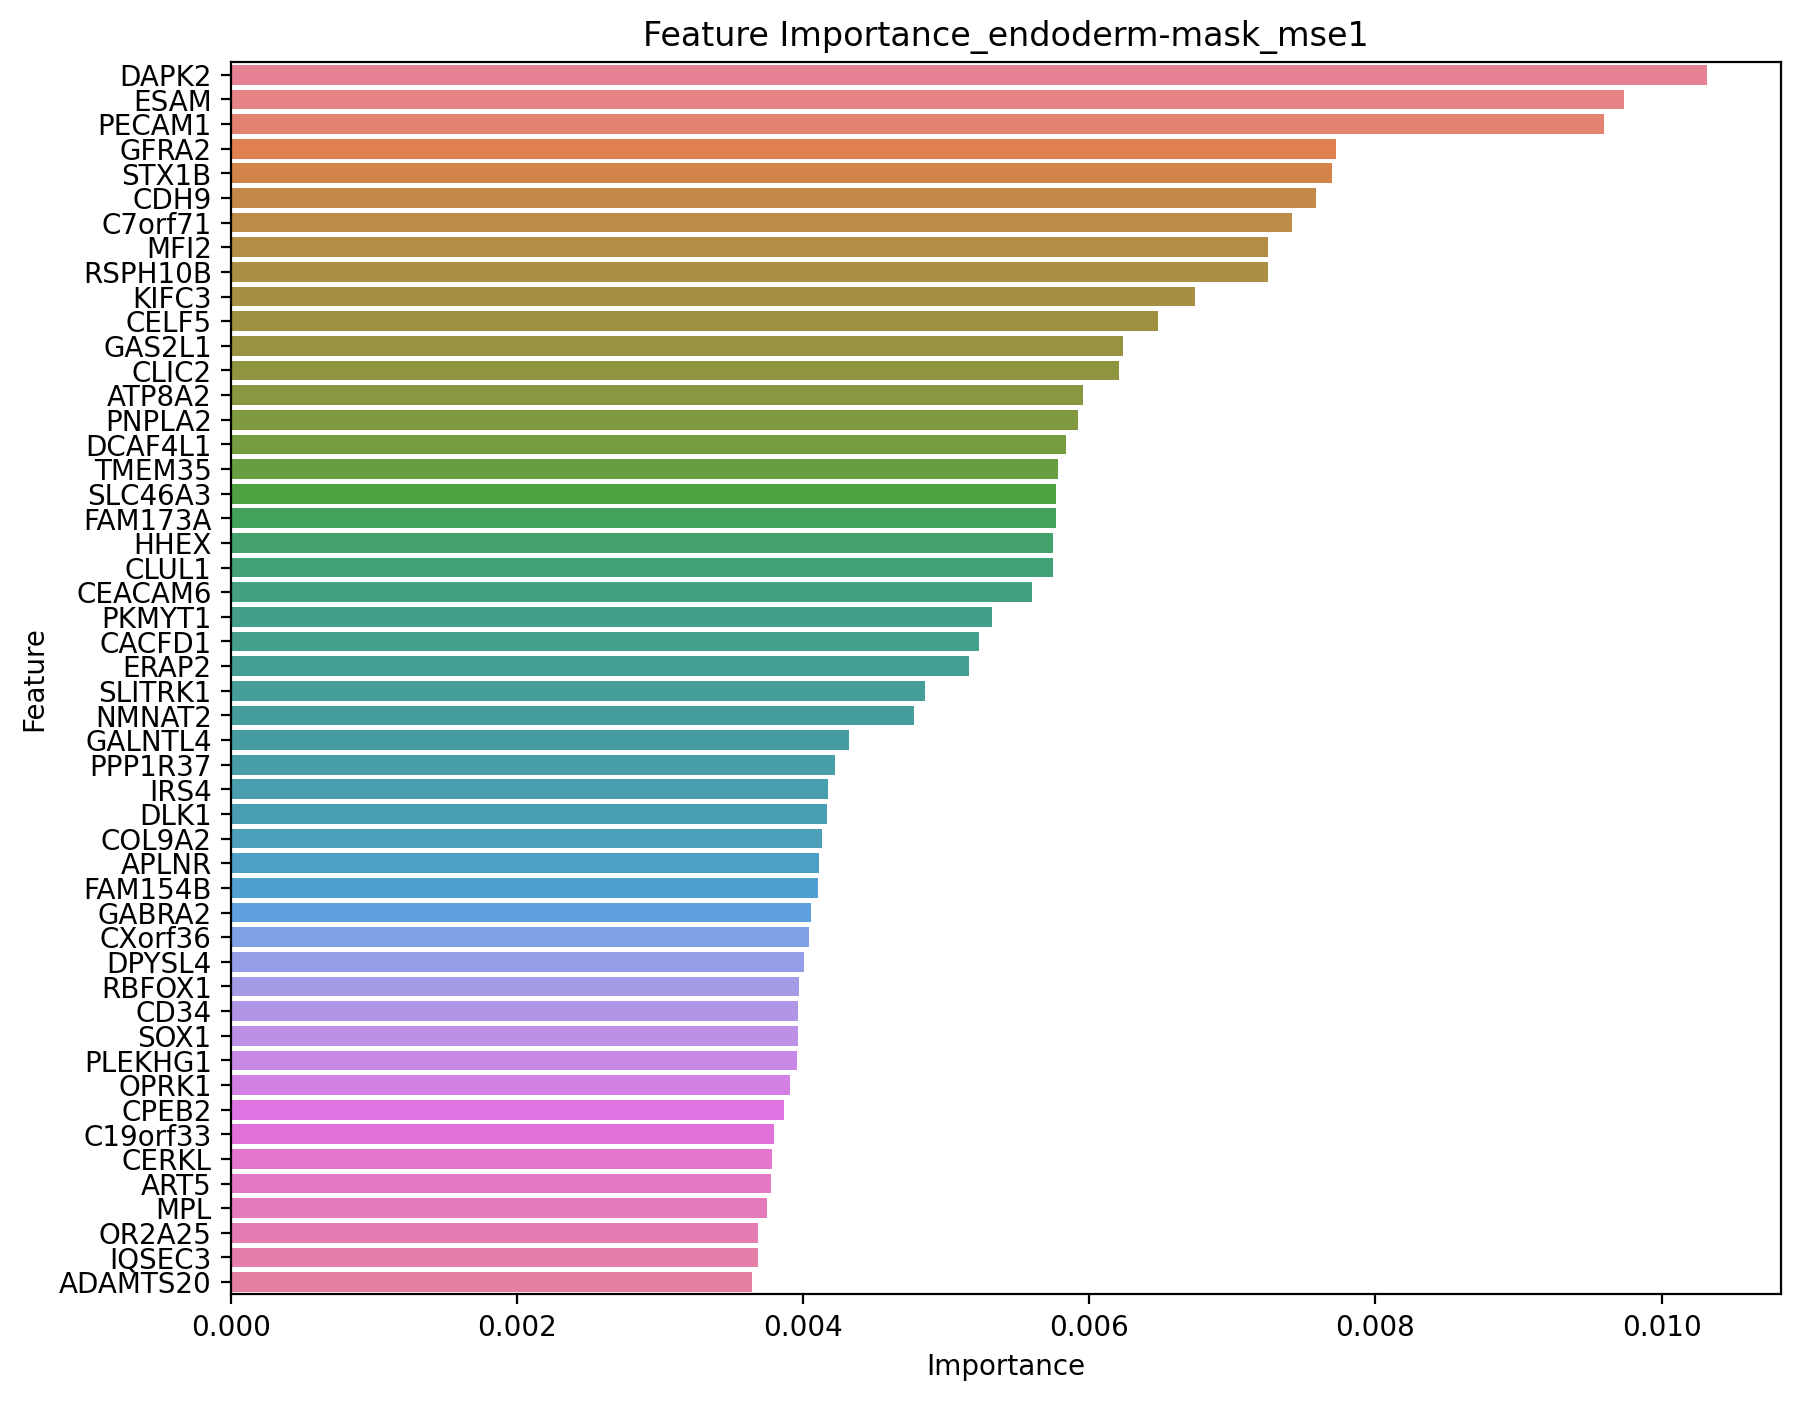

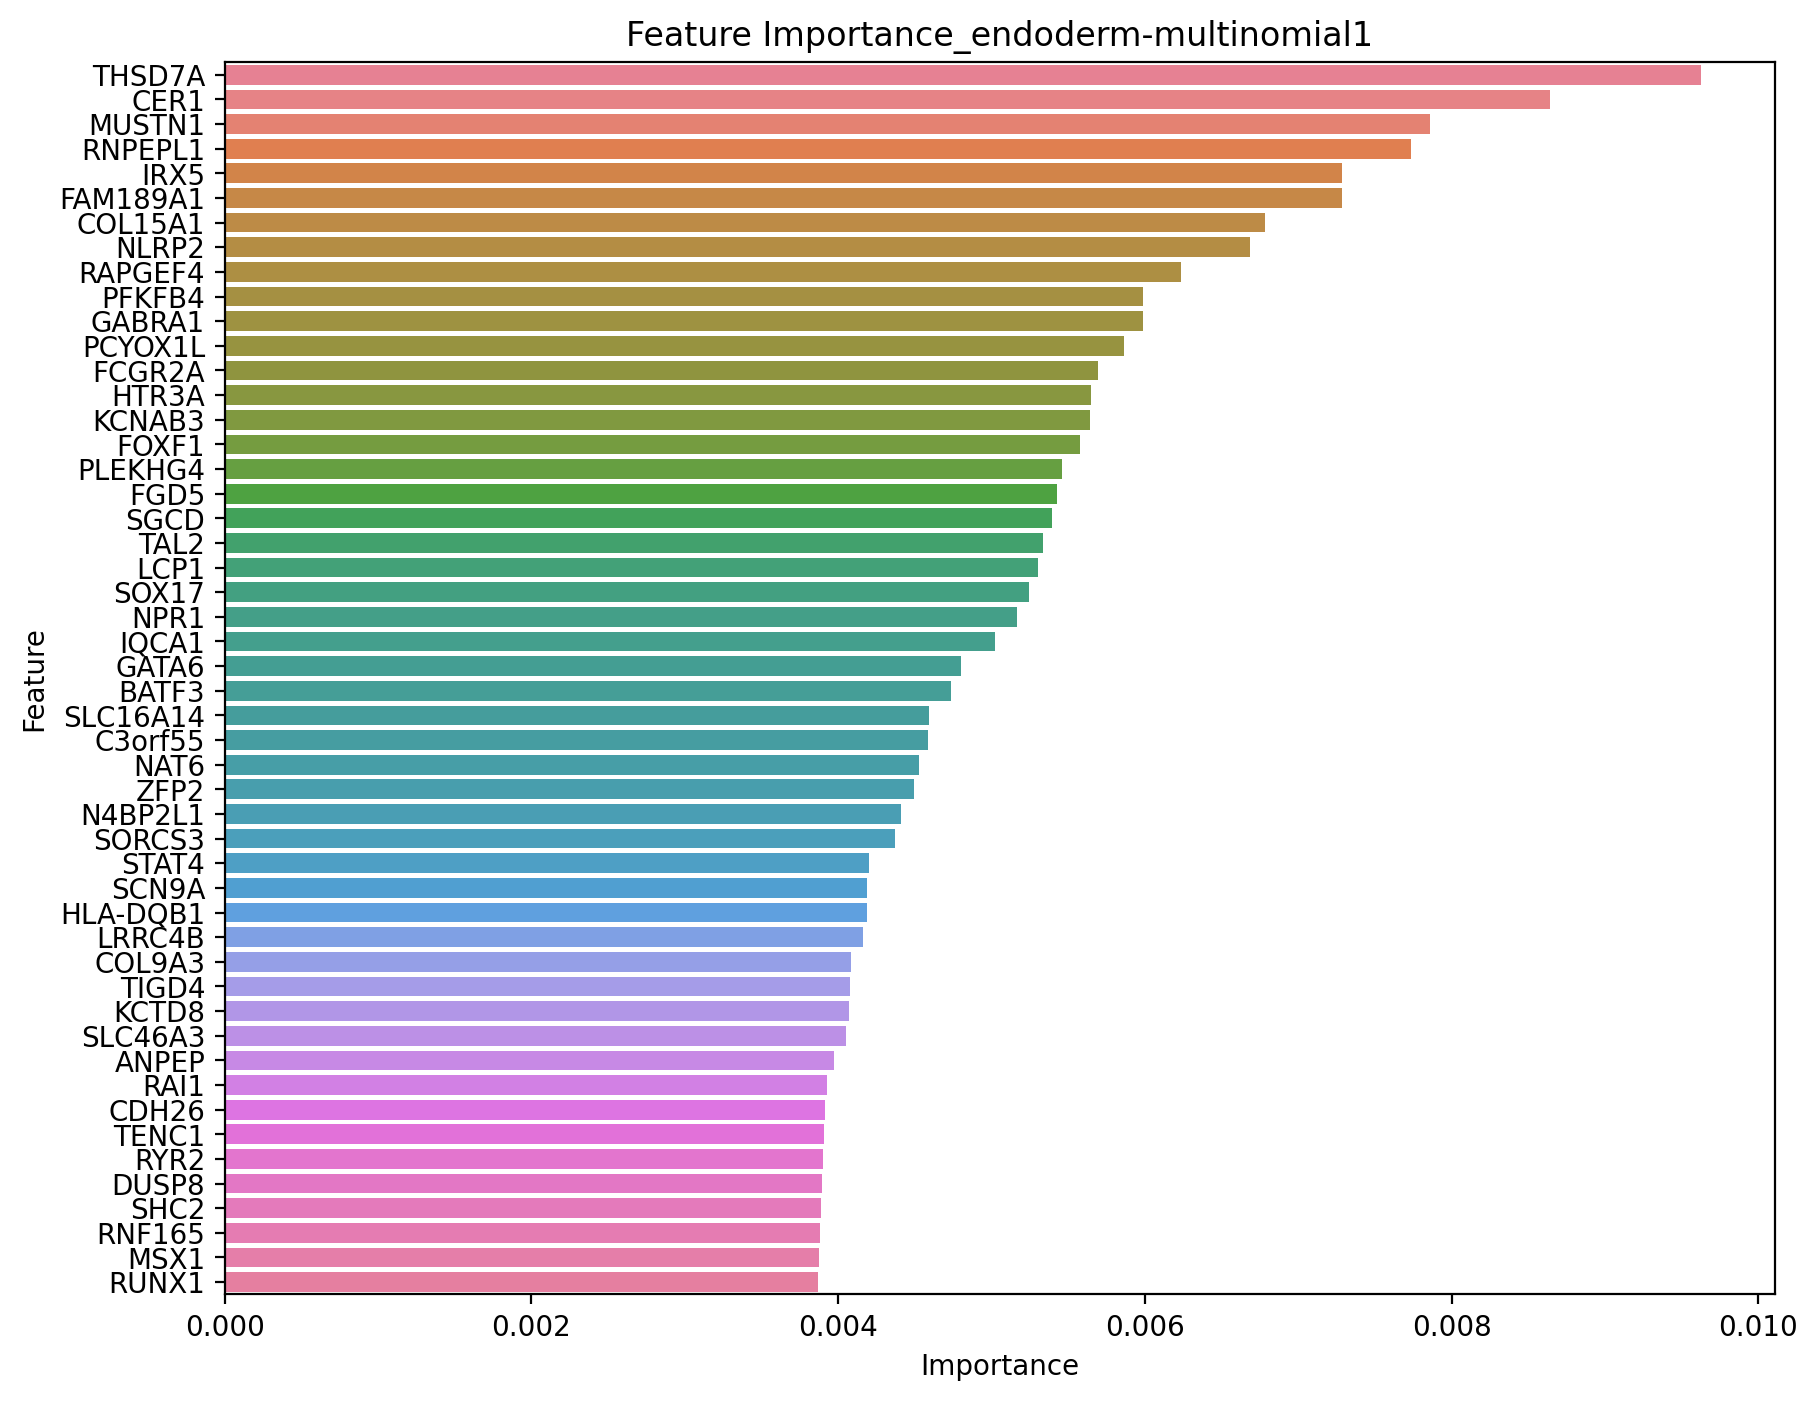

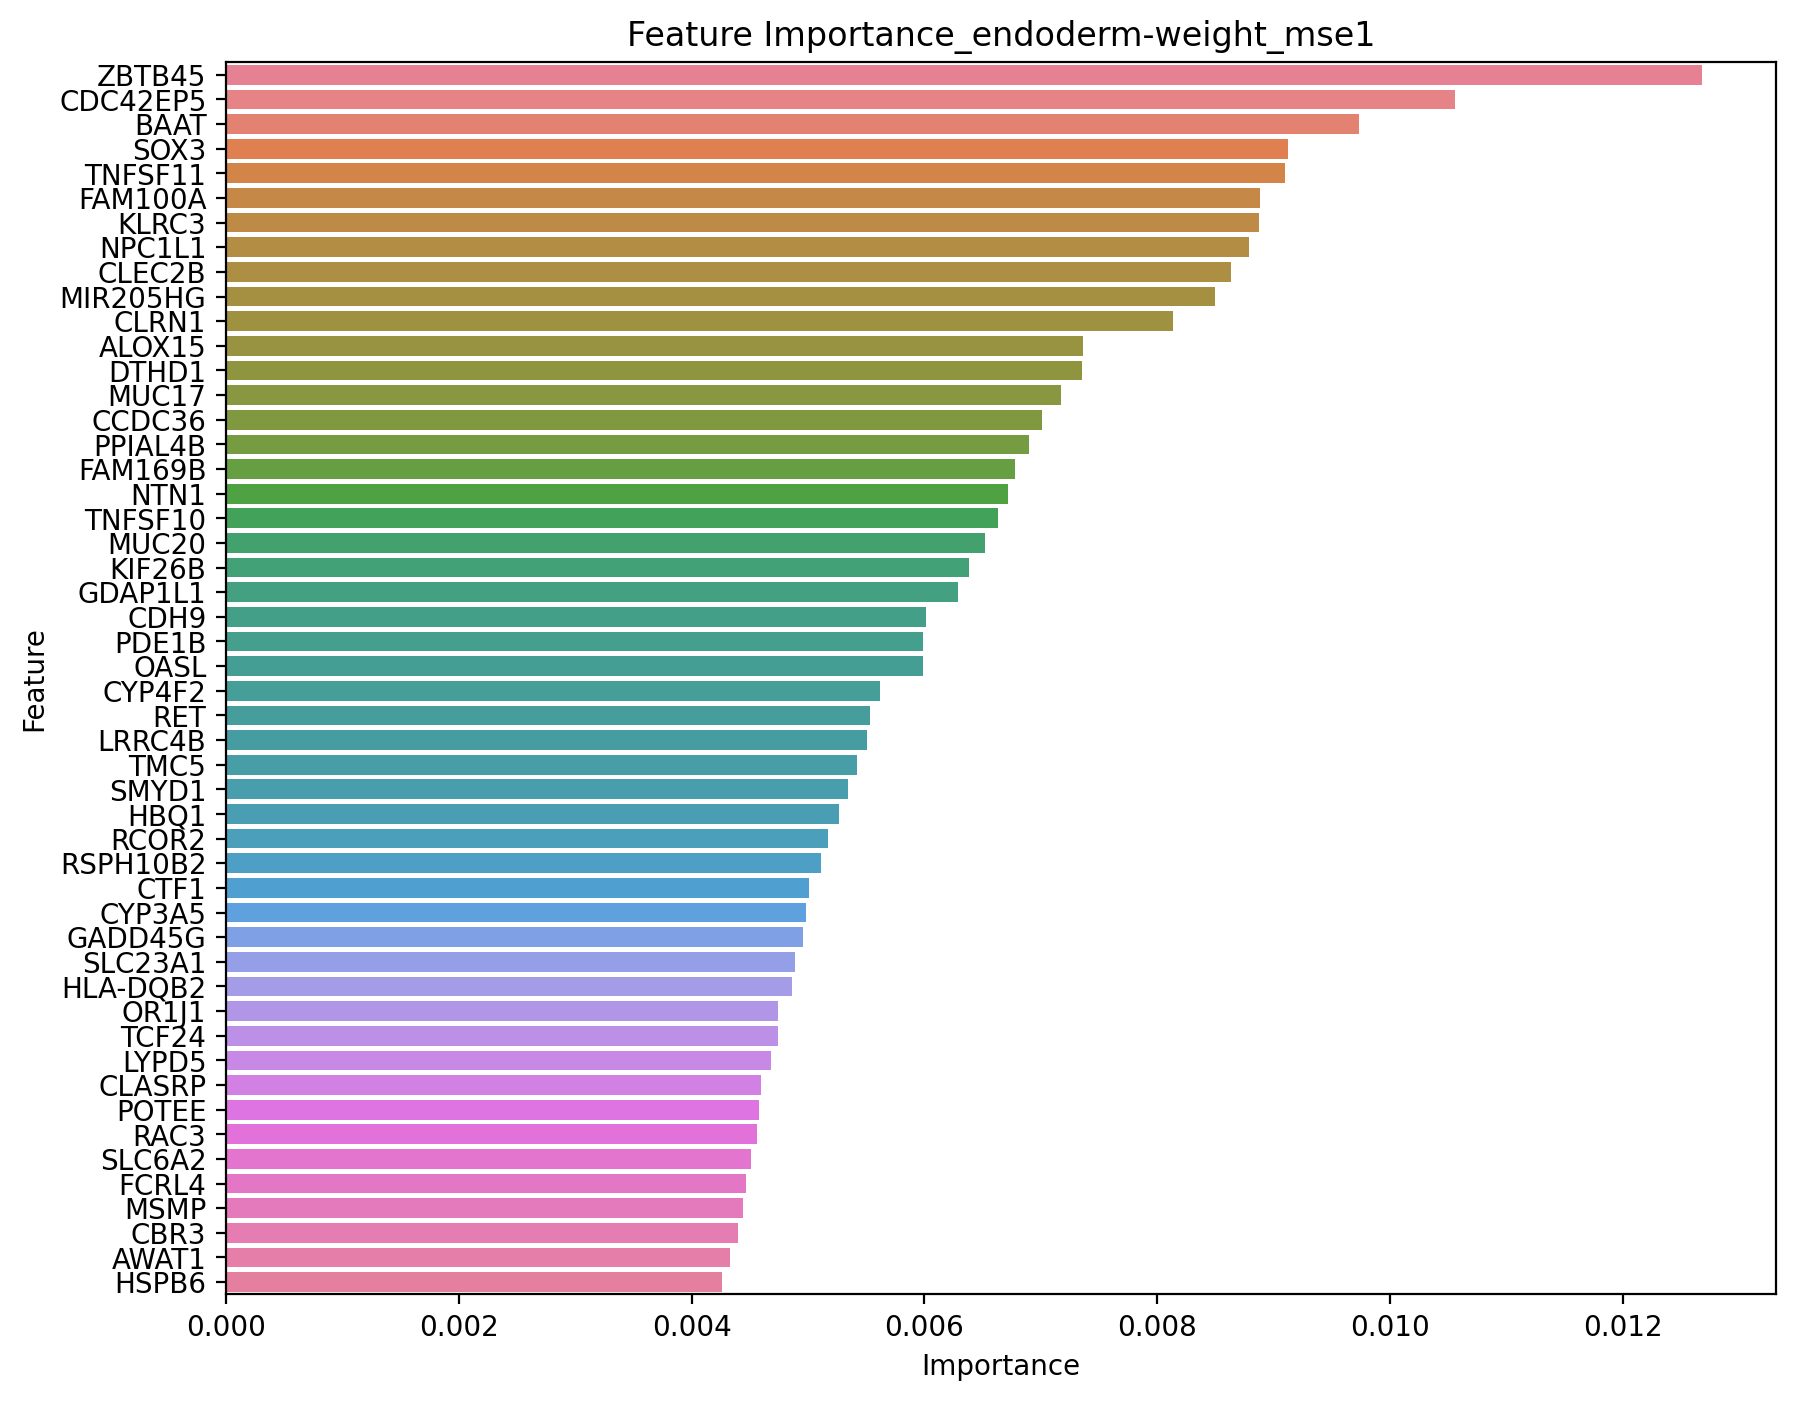

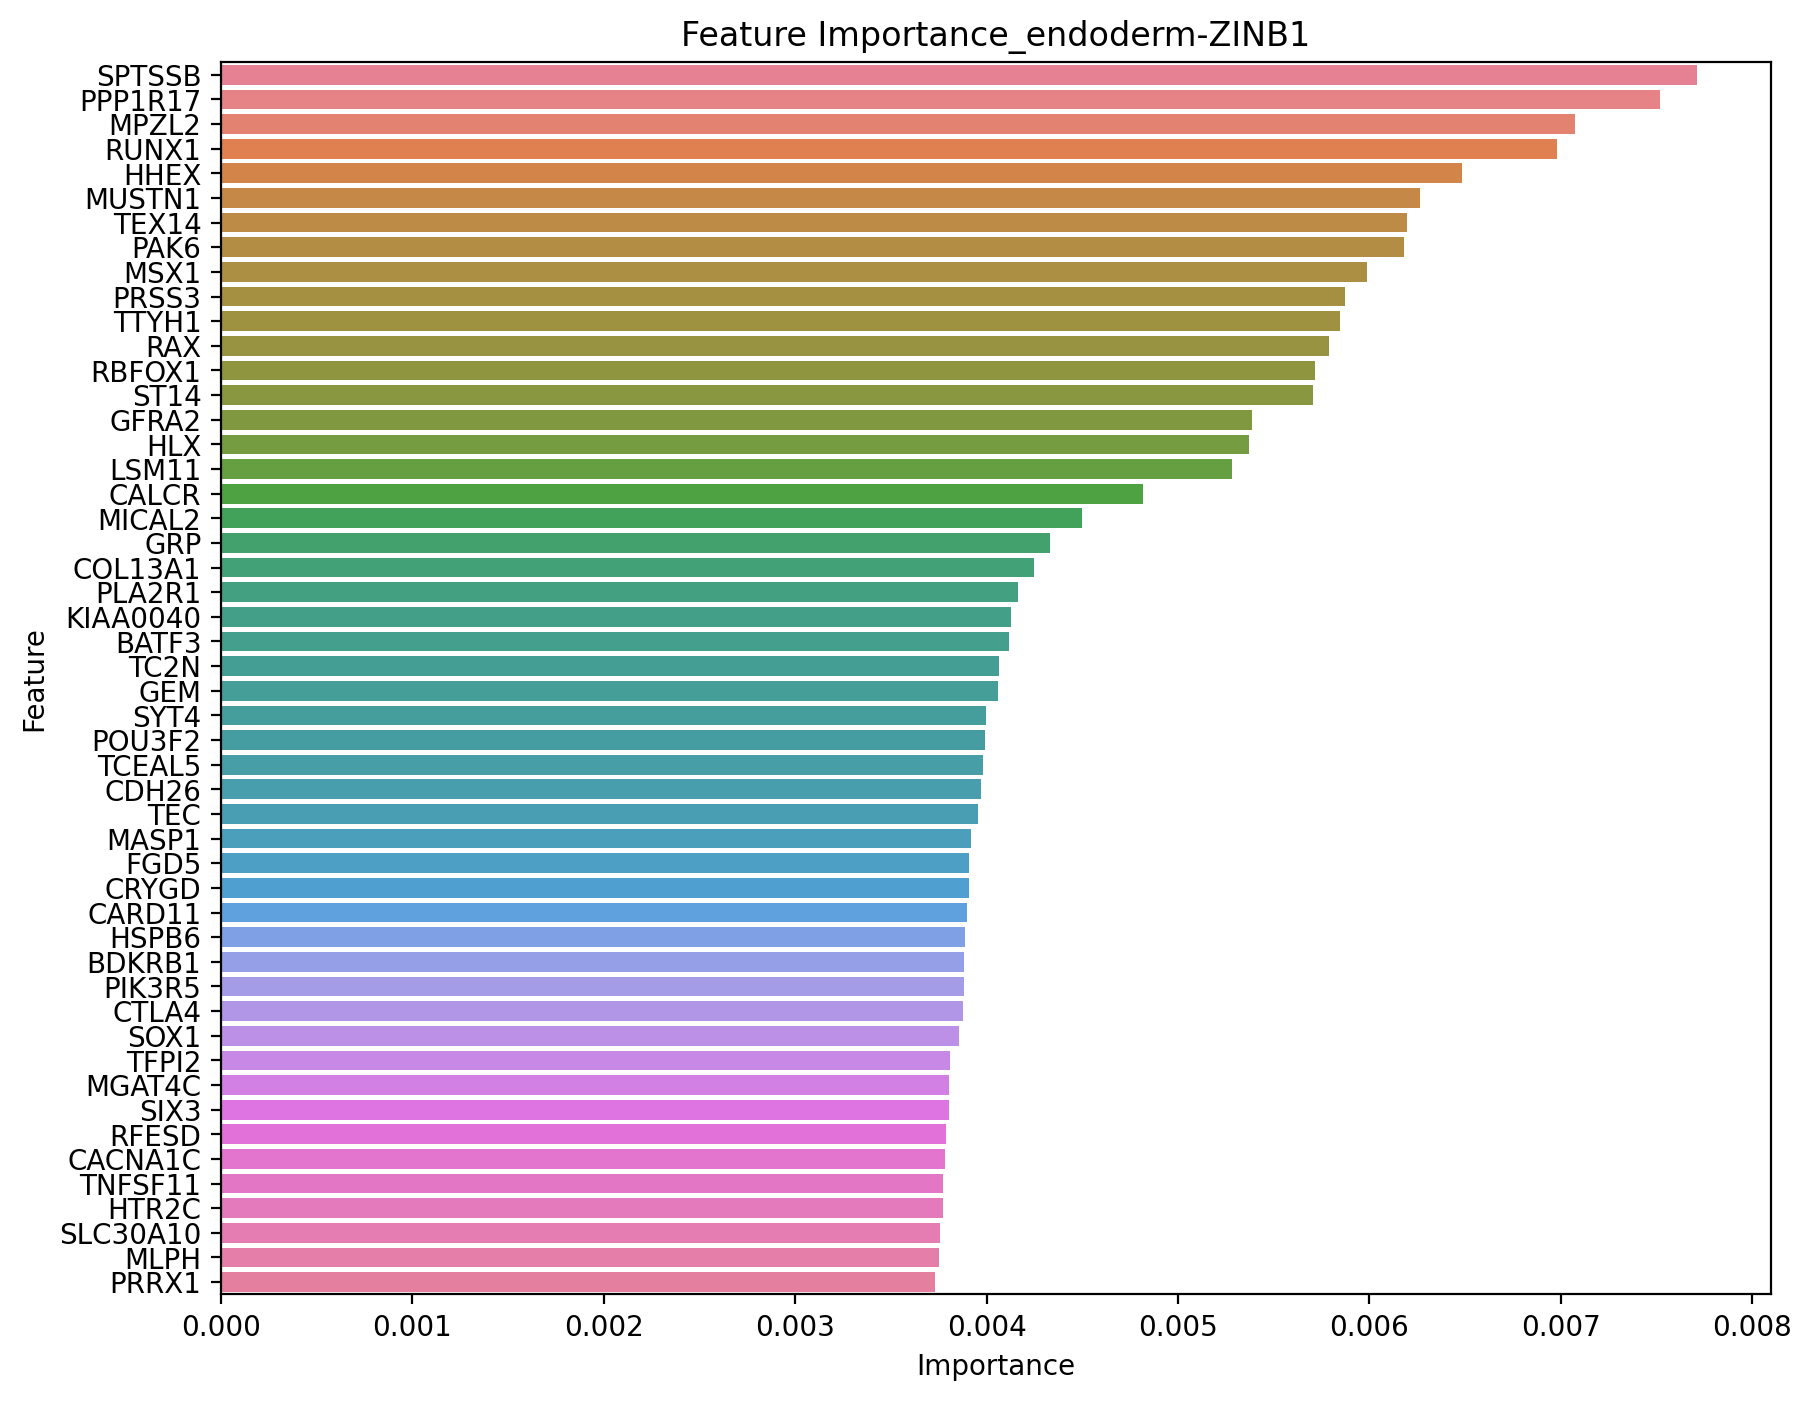

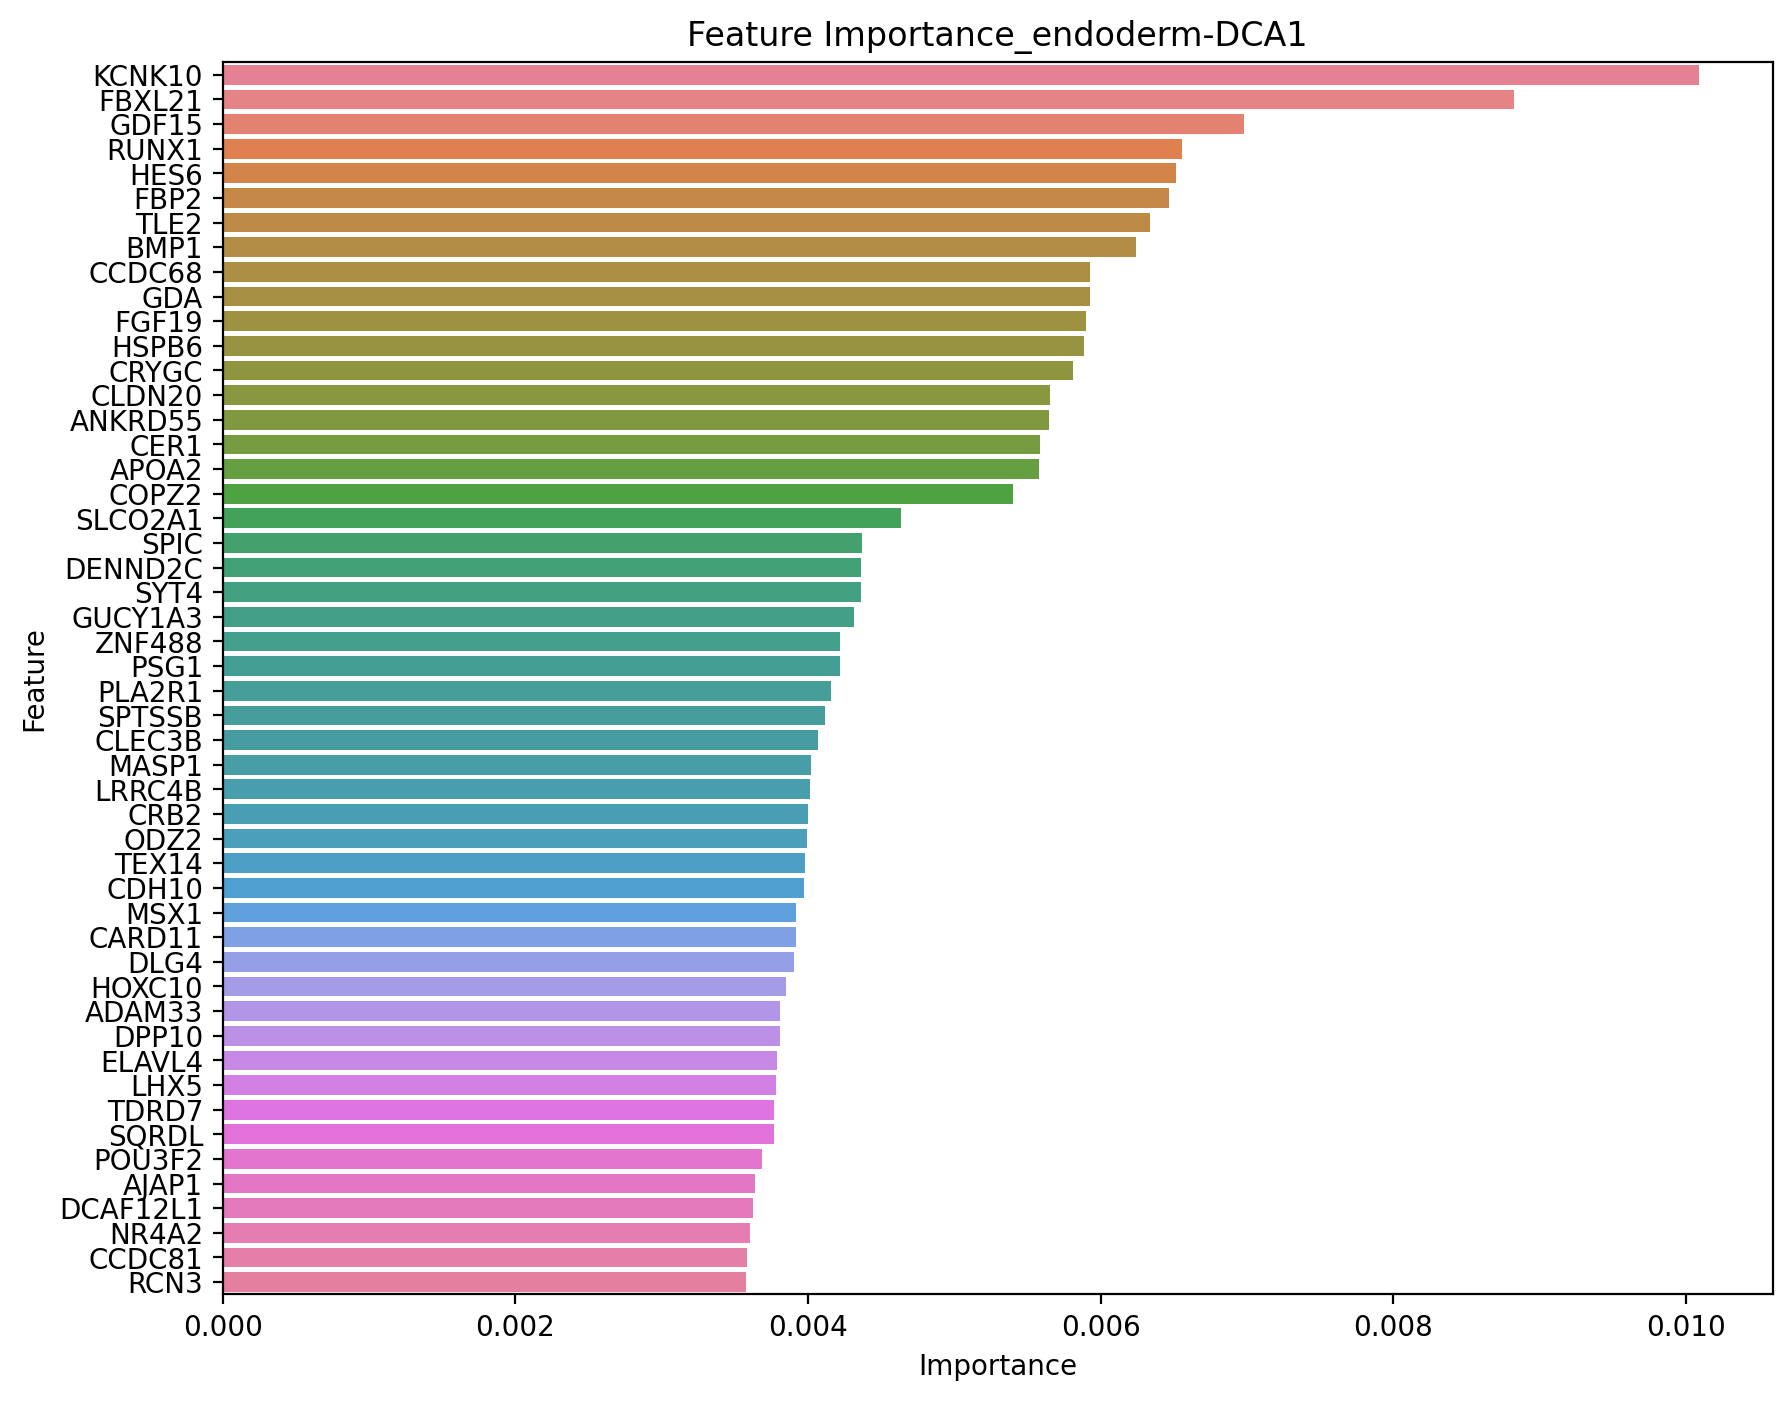

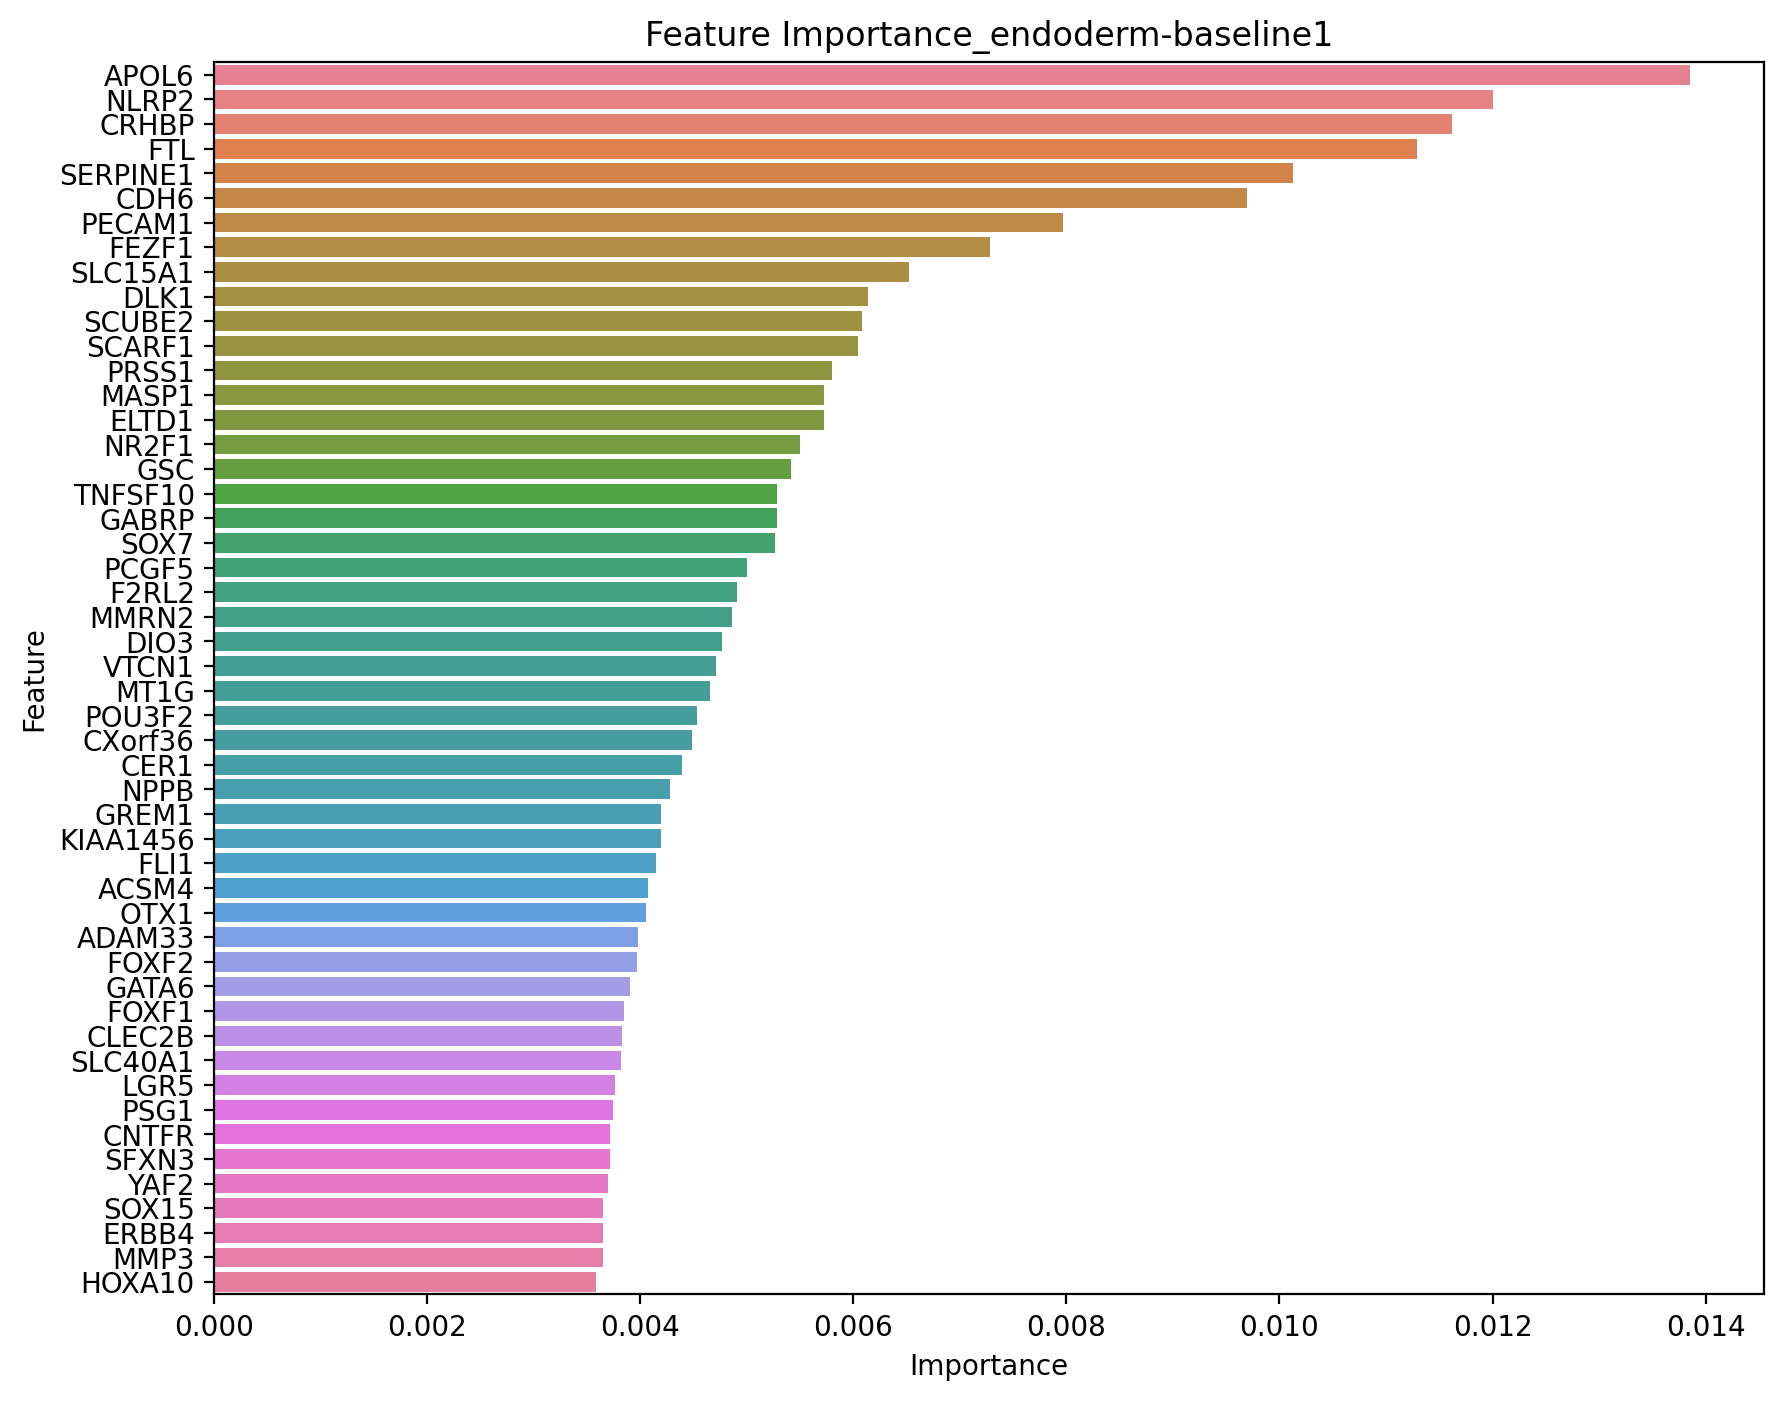

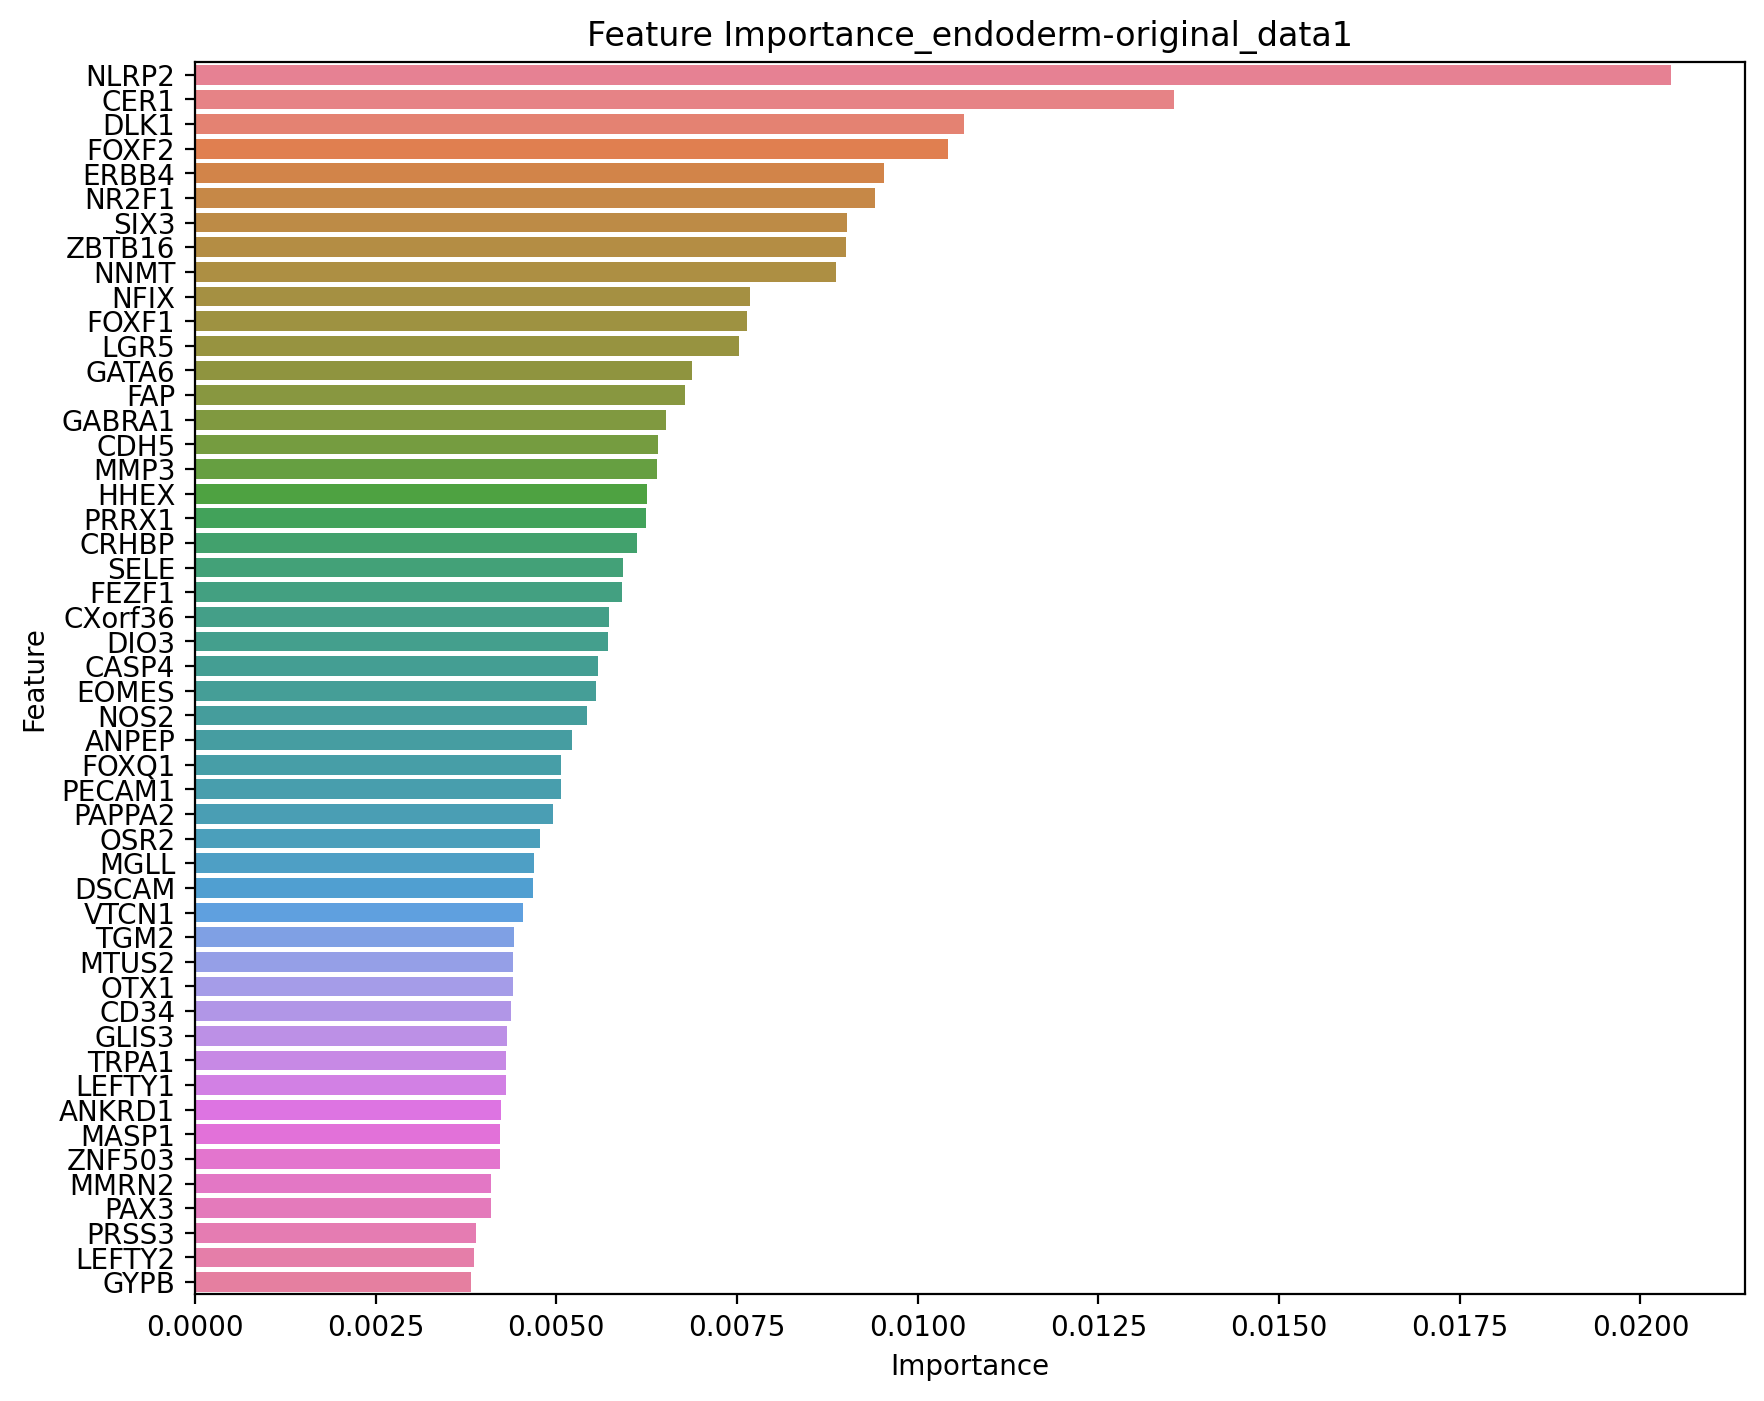

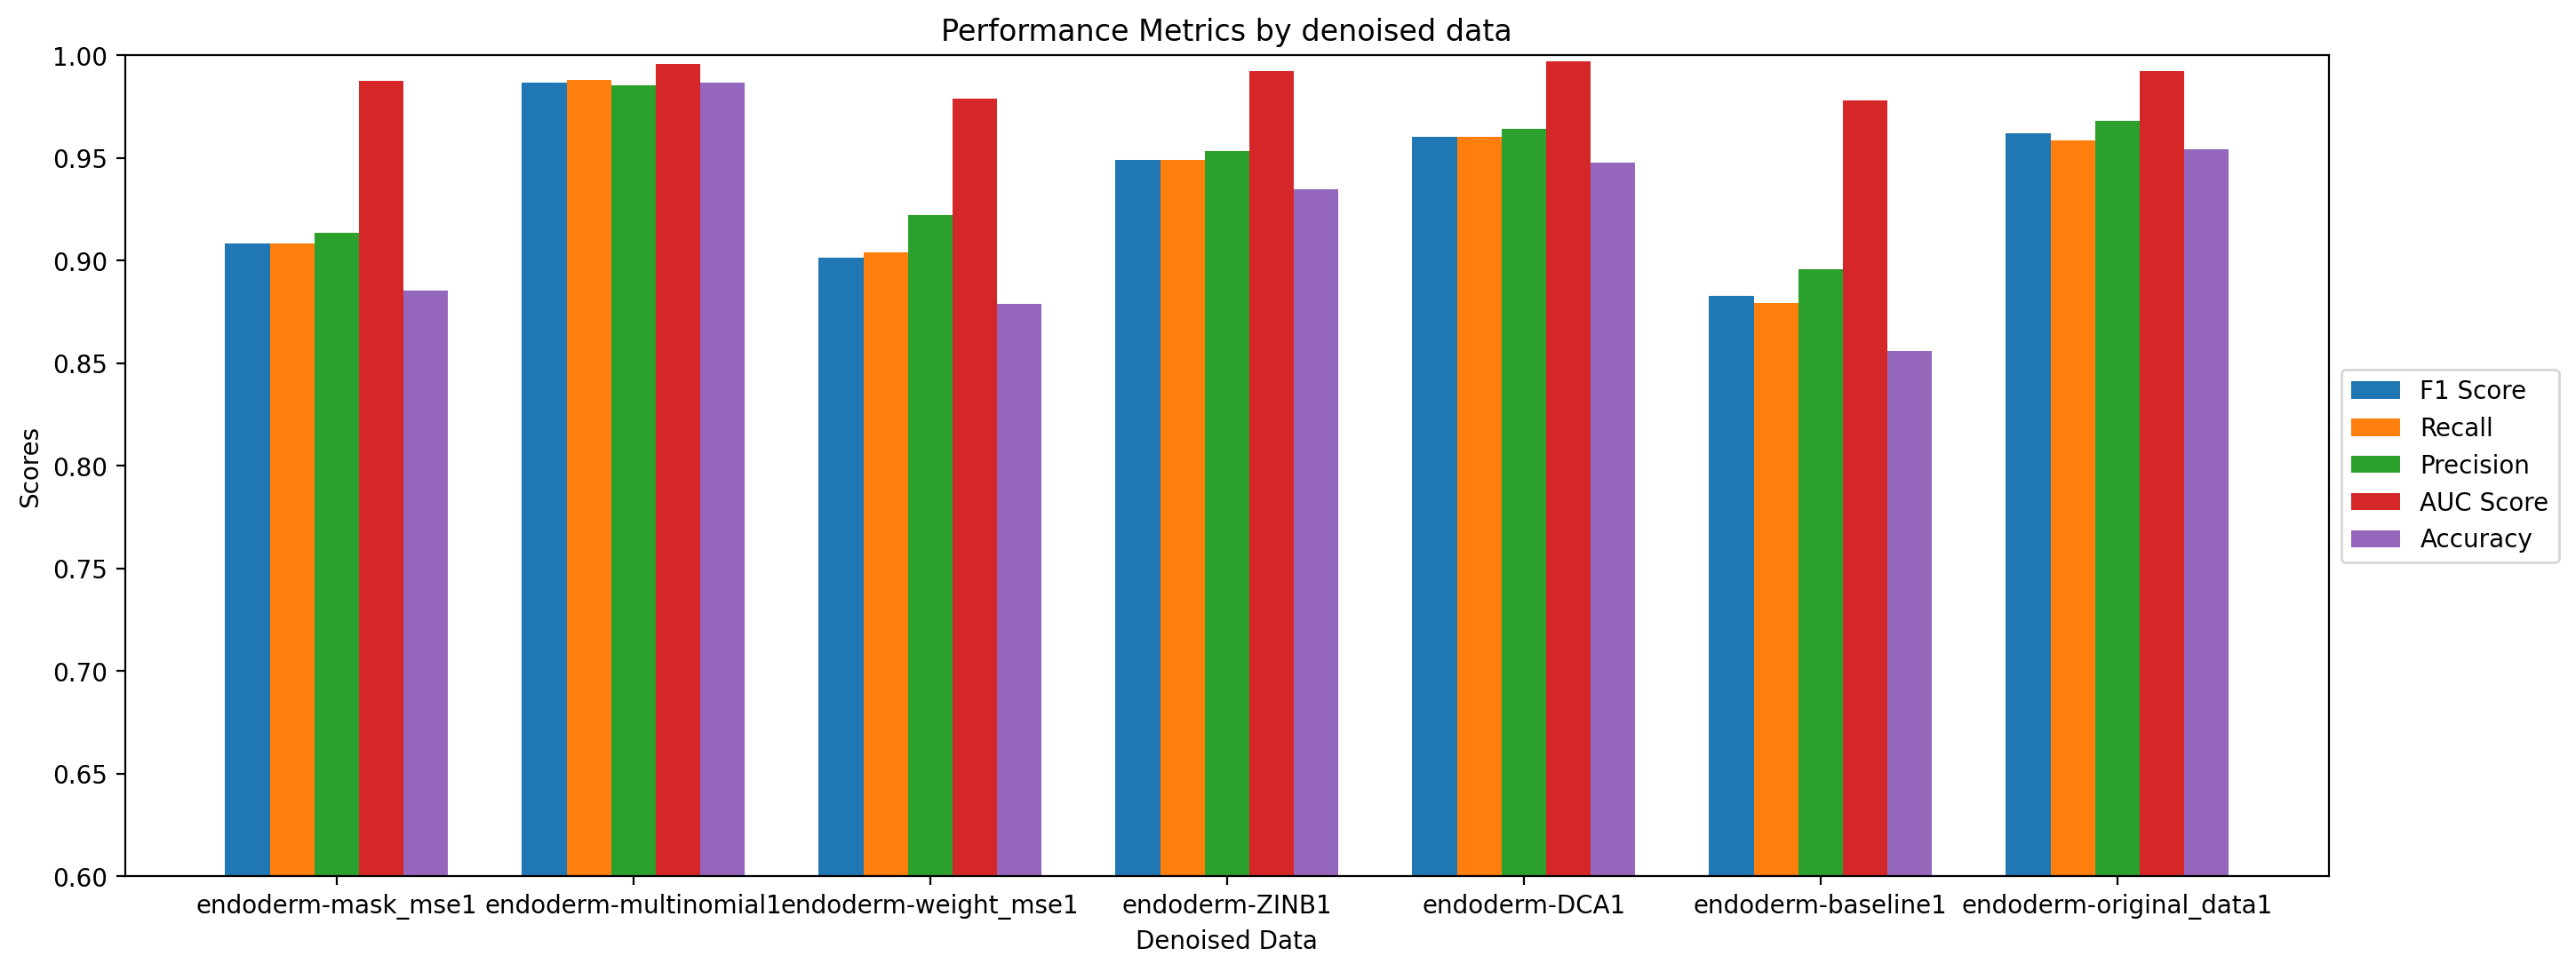

In [14]:
#For simulated data, please start another chunk!!

# Goal: Compare different denoising methods of the same original dataset

# TODO: for Endoderm, baseline denoised data is still missing

# file_paths are used to fetch the dataset
file_paths = [
      'results/endoderm/results-mask mse.h5ad',
      'results/endoderm/results-multinomial.h5ad',
      'results/endoderm/results-weight mse.h5ad',
      'results/endoderm/results-ZINB.h5ad',
      'results/endoderm/mean.tsv',
      'results/baseline_denoise/mean_replaced.csv', #endoderm_mean_replaced.csv'
      'data/endoderm/endoderm.csv'
  ]

# file_names are used to define paths saving feature importance for each dataset, please name properly
# suggested: datasetName-denoiseMethod
file_names = [
      'endoderm-mask_mse1',
      'endoderm-multinomial1',
      'endoderm-weight_mse1',
      'endoderm-ZINB1',
      'endoderm-DCA1',
      'endoderm-baseline1',
      'endoderm-original_data1'
  ]

# save_path_df are used to save classification results, please name properly
# suggested: classification_results/datasetName
save_path_df = 'classification_results/endoderm_scores1.csv'

# save_path_viz is used to save the classification results visualization, please name properly
# suggested: classification_results/datasetName
save_path_viz = 'classification_results/endoderm1.png'

final_results = run_classification(file_paths, file_names, save_path_df, save_path_viz)


# Feature Importance

In [ ]:
orig = pd.read_csv()
